# Dcifer IBD spatial analysis combining TES, HFS and REACT2 data from 2022

This notebook analyses the spatial structure of IBD relatedness between samples from different provinces from 2022

# TODO: check used packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from genomic_tools.plotting import make_pie, make_hist
from genomic_tools.pairwise import classify_ibd_per_label, high_ibd_frac_per_cat, show_ibd_frac_per_cat
from genomic_tools.pairwise import connectivity_map, mean_high_ibd_frac_vs_dist
from genomic_tools.microhaplotypes import He_from_samples
from time import time
from scipy import stats
import geopandas
from spatial_tools import clustering
from stat_tools import errors, glm
import contextily as ctx
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import cm
from genmoz_pytools import notebook_pytools
import statsmodels.api as sm
from stat_tools import tables

ModuleNotFoundError: No module named 'spatial_tools'

## Importing data

In [2]:
#Metadata
pipeline_results_path  = "/home/apujol/isglobal/manuscripts/importation_relatedness/data/"
all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')
metadata = all_data_div_covered_samples[['sampleID', 'nida', 'study', 'run_id_resmark', 'year', \
                                         'region', 'province', 'district', \
                                         'us', 'age', 'sex', 'parasitemia', \
                                         '1.2 Selecione o distrito do estudo.',
                                         'date', '3.2 Data da Notificação.', \
                                         'occupation', \
                                         'travel', 'travel_prov', 'travel_dist', \
                                         'Data de Ida.', 'Data de regresso', \
                                         'latitude', 'longitude', 'travel_days', \
                                         'travel_days_728', 'source']].drop_duplicates()

metadata.loc[metadata['district'].isnull(), 'district'] = metadata.loc[metadata['district'].isnull(), '1.2 Selecione o distrito do estudo.']
metadata.loc[metadata['province'] == 'Maputo Provincia', 'province'] = 'Maputo'
metadata.loc[metadata['province'] == 'Maputo Cidade', 'province'] = 'Maputo City'
metadata['date'] = pd.to_datetime(metadata['date'])

/tmp/ipykernel_30064/99138227.py:3: DtypeWarning: Columns (12,13,15,18,19,22,24,25,28,29,30,31,32,33,34,35,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'all_2022_allele_data_global_max_div_50cov_loci_v2.csv')


## Loading IBD results

In [3]:
ibd_data_path = pipeline_results_path
ibd_res_filename = ibd_data_path + "ibd_results.csv"
ibd_res = pd.read_csv(ibd_res_filename)
ibd_pval_filename = ibd_data_path + "ibd_results_p_value.csv"
ibd_pval = pd.read_csv(ibd_pval_filename)
ibd_res.index = ibd_res.columns
ibd_pval.index = ibd_pval.columns

## Visualise IBD results

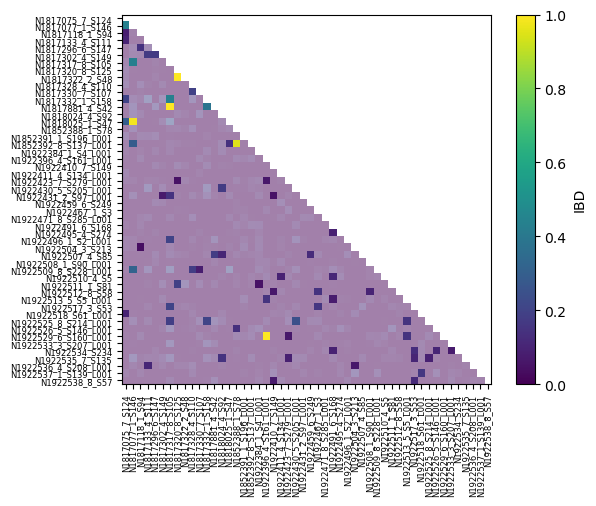

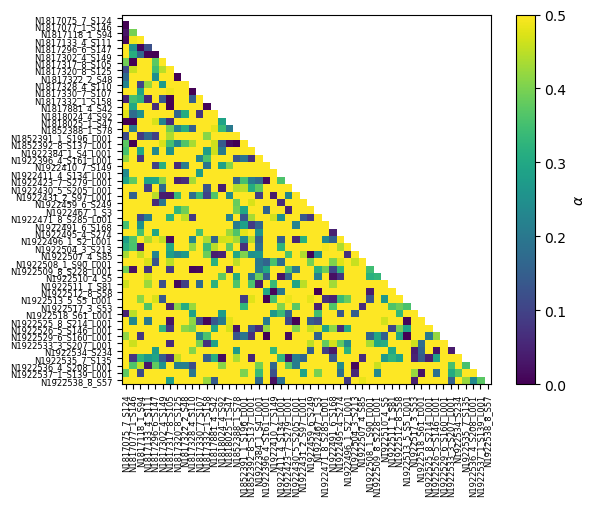

In [4]:
i, j = 0, 50
plt.imshow(np.array(ibd_res.iloc[i:j,i:j]), alpha = .5 + .5*np.array(np.array(ibd_pval.iloc[i:j,i:j]) < .05, dtype = float))
plt.yticks(np.arange(len(ibd_res.iloc[i:j,i:j])), ibd_res.iloc[i:j,i:j].index, fontsize = 6)
plt.xticks(np.arange(len(ibd_res.iloc[i:j,i:j])), ibd_res.iloc[i:j,i:j].index, rotation = 90, fontsize = 6)
plt.colorbar(label = 'IBD')
plt.show()

i, j = 0, 50
plt.imshow(np.array(ibd_pval.iloc[i:j,i:j]))
plt.yticks(np.arange(len(ibd_pval.iloc[i:j,i:j])), ibd_pval.iloc[i:j,i:j].index, fontsize = 6)
plt.xticks(np.arange(len(ibd_pval.iloc[i:j,i:j])), ibd_pval.iloc[i:j,i:j].index, rotation = 90, fontsize = 6)
plt.colorbar(label = r'$\alpha$')
plt.show()

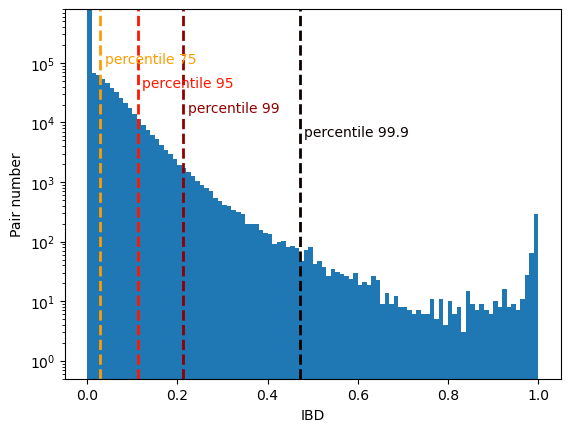

In [5]:
ylims = [.5, 8*10**5]

ibd_values = np.array(ibd_res).flatten()
plt.hist(ibd_values,100)
p999 = np.nanpercentile(ibd_values, 99.9)
plt.vlines(p999, ylims[0], ylims[1], color = cm.hot(.0), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99.9", xy = [p999 +.01, 6*10**3], color = cm.hot(.0))
p99 = np.nanpercentile(ibd_values, 99)
plt.vlines(p99, ylims[0], ylims[1], color = cm.hot(.2), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99", xy = [p99 +.01, 1.5*10**4], color = cm.hot(.2))
p95 = np.nanpercentile(ibd_values, 95)
plt.vlines(p95, ylims[0], ylims[1], color = cm.hot(.4), lw = 2, linestyle = '--')
plt.annotate(r"percentile 95", xy = [p95 +.01, 4*10**4], color = cm.hot(.4))
p75 = np.nanpercentile(ibd_values, 75)
plt.vlines(p75, ylims[0], ylims[1], color = cm.hot(.6), lw = 2, linestyle = '--')
plt.annotate(r"percentile 75", xy = [p75 +.01, 10**5], color = cm.hot(.6))
plt.yscale('log')
plt.xlabel('IBD')
plt.ylabel('Pair number')
plt.ylim(ylims)
plt.show()

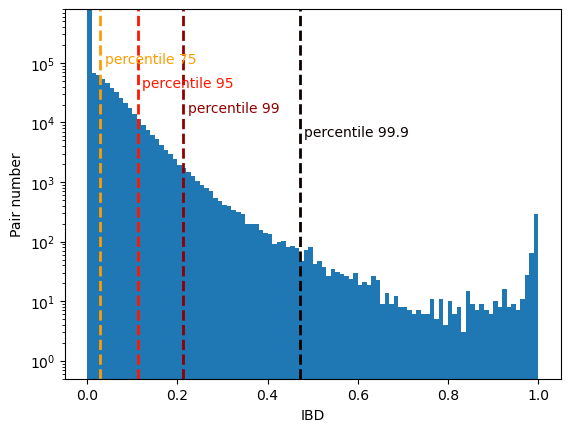

In [133]:
ylims = [.5, 8*10**5]

ibd_values = np.array(ibd_res).flatten()
plt.hist(ibd_values,100)
p999 = np.nanpercentile(ibd_values, 99.9)
plt.vlines(p999, ylims[0], ylims[1], color = cm.hot(.0), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99.9", xy = [p999 +.01, 6*10**3], color = cm.hot(.0))
p99 = np.nanpercentile(ibd_values, 99)
plt.vlines(p99, ylims[0], ylims[1], color = cm.hot(.2), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99", xy = [p99 +.01, 1.5*10**4], color = cm.hot(.2))
p95 = np.nanpercentile(ibd_values, 95)
plt.vlines(p95, ylims[0], ylims[1], color = cm.hot(.4), lw = 2, linestyle = '--')
plt.annotate(r"percentile 95", xy = [p95 +.01, 4*10**4], color = cm.hot(.4))
p75 = np.nanpercentile(ibd_values, 75)
plt.vlines(p75, ylims[0], ylims[1], color = cm.hot(.6), lw = 2, linestyle = '--')
plt.annotate(r"percentile 75", xy = [p75 +.01, 10**5], color = cm.hot(.6))
plt.yscale('log')
plt.xlabel('IBD')
plt.ylabel('Pair number')
plt.ylim(ylims)
plt.show()

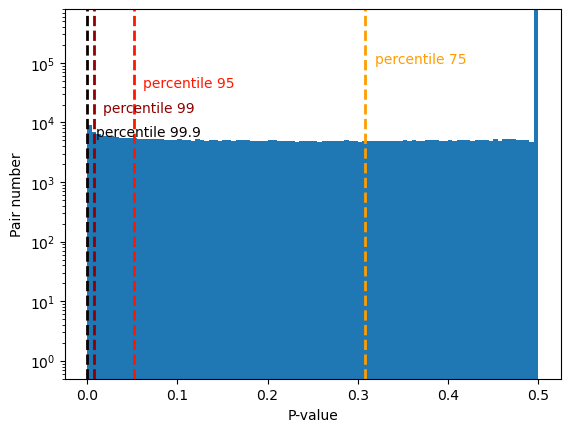

In [134]:
ylims = [.5, 8*10**5]

p_values = np.array(ibd_pval).flatten()
plt.hist(p_values,100)
p999 = np.nanpercentile(p_values, 0.1)
plt.vlines(p999, ylims[0], ylims[1], color = cm.hot(.0), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99.9", xy = [p999 +.01, 6*10**3], color = cm.hot(.0))
p99 = np.nanpercentile(p_values, 1)
plt.vlines(p99, ylims[0], ylims[1], color = cm.hot(.2), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99", xy = [p99 +.01, 1.5*10**4], color = cm.hot(.2))
p95 = np.nanpercentile(p_values, 5)
plt.vlines(p95, ylims[0], ylims[1], color = cm.hot(.4), lw = 2, linestyle = '--')
plt.annotate(r"percentile 95", xy = [p95 +.01, 4*10**4], color = cm.hot(.4))
p75 = np.nanpercentile(p_values, 25)
plt.vlines(p75, ylims[0], ylims[1], color = cm.hot(.6), lw = 2, linestyle = '--')
plt.annotate(r"percentile 75", xy = [p75 +.01, 10**5], color = cm.hot(.6))
plt.yscale('log')
plt.xlabel(r'P-value')
plt.ylabel('Pair number')
plt.ylim(ylims)
plt.show()

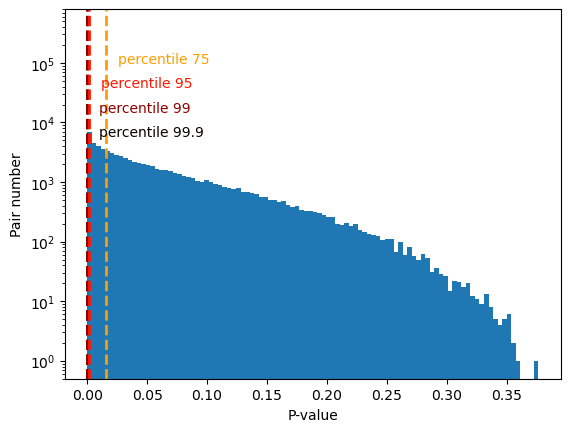

In [135]:
ylims = [.5, 8*10**5]

p_values = np.array(ibd_pval).flatten()[ibd_values > .1]
plt.hist(p_values,100)
p999 = np.nanpercentile(p_values, 0.1)
plt.vlines(p999, ylims[0], ylims[1], color = cm.hot(.0), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99.9", xy = [p999 +.01, 6*10**3], color = cm.hot(.0))
p99 = np.nanpercentile(p_values, 1)
plt.vlines(p99, ylims[0], ylims[1], color = cm.hot(.2), lw = 2, linestyle = '--')
plt.annotate(r"percentile 99", xy = [p99 +.01, 1.5*10**4], color = cm.hot(.2))
p95 = np.nanpercentile(p_values, 5)
plt.vlines(p95, ylims[0], ylims[1], color = cm.hot(.4), lw = 2, linestyle = '--')
plt.annotate(r"percentile 95", xy = [p95 +.01, 4*10**4], color = cm.hot(.4))
p75 = np.nanpercentile(p_values, 25)
plt.vlines(p75, ylims[0], ylims[1], color = cm.hot(.6), lw = 2, linestyle = '--')
plt.annotate(r"percentile 75", xy = [p75 +.01, 10**5], color = cm.hot(.6))
plt.yscale('log')
plt.xlabel(r'P-value')
plt.ylabel('Pair number')
plt.ylim(ylims)
plt.show()

### Adding metadata and GPS locations

In [4]:
ibd_res_meta = pd.merge(ibd_res, metadata, left_index = True, right_on = 'sampleID', how = 'left')
ibd_pval_meta = pd.merge(ibd_pval, metadata, left_index = True, right_on = 'sampleID', how = 'left')

In [5]:
react_mask = (ibd_res_meta['source'] == 'REACT2')&(ibd_res_meta['province'] == 'Maputo')
np.sum(ibd_res_meta.loc[react_mask, 'travel'] == 1)

110

In [6]:
np.sum(react_mask&ibd_res_meta['travel'].notnull())

213

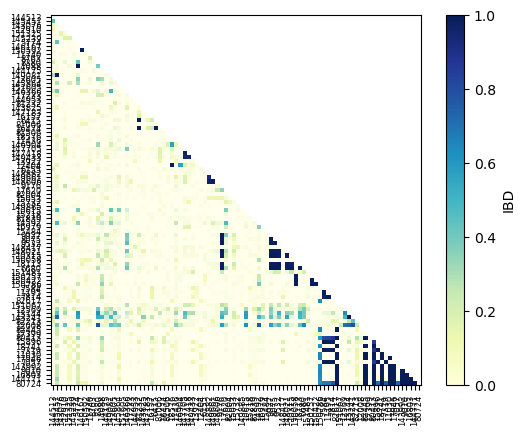

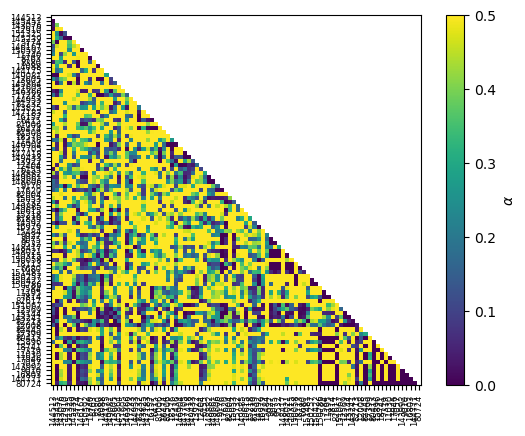

In [9]:
mask_i = ibd_res_meta['province'] == 'Nampula'
mask_j = np.zeros(len(ibd_res_meta.columns), dtype = bool)
mask_j[:len(ibd_res_meta)] = ibd_res_meta['province'] == 'Nampula'

plt.imshow(np.array(ibd_res_meta.loc[mask_i,mask_j]), alpha = .5 + .5*np.array(np.array(ibd_pval_meta.loc[mask_i,mask_j]) < .05, dtype = float), \
          cmap = "YlGnBu")
plt.yticks(np.arange(len(ibd_res_meta.loc[mask_i,mask_j])), ibd_res_meta.loc[mask_i,mask_j].index, fontsize = 6)
plt.xticks(np.arange(len(ibd_res_meta.loc[mask_i,mask_j])), ibd_res_meta.loc[mask_i,mask_j].index, rotation = 90, fontsize = 6)
plt.colorbar(label = 'IBD')
plt.show()

plt.imshow(np.array(ibd_pval_meta.loc[mask_i,mask_j]))
plt.yticks(np.arange(len(ibd_pval_meta.loc[mask_i,mask_j])), ibd_pval_meta.loc[mask_i,mask_j].index, fontsize = 6)
plt.xticks(np.arange(len(ibd_pval_meta.loc[mask_i,mask_j])), ibd_pval_meta.loc[mask_i,mask_j].index, rotation = 90, fontsize = 6)
plt.colorbar(label = r'$\alpha$')
plt.show()

In [7]:
list_locs = {
    'Manhica' : [32.80722050, -25.40221980], #From Pau Cisteró excel
    'Maputo' : [32.64216410, -25.02049992], #Magude
    'Maputo Cidade' : [32.576388888888889, -25.915277666666],
    'Maputo City' : [32.576388888888889, -25.915277666666],
    'Montepuez' : [38.99972150, -13.12555980], #From Pau Cisteró excel
    'Chokwe' : [33.005166666666666667, -24.5252777777777777],
    'Moatize' : [33.73333040, -16.11666620], #From Pau Cisteró excel
    'Dondo' : [34.75, -19.6166666666666667],
    'Magude' : [32.64216410, -25.02049992], #From Pau Cisteró excel
    'Ilha Josina' : [32.92210000, -25.09330000], #From Pau Cisteró excel
    'Xinavane' : [32.791885, -25.048534],
    'Panjane' : [32.352430, -24.899469],
    'Motaze' : [32.860569, -24.810357],
    'Mapulanguene' : [32.081602, -24.491015],
    'Taninga' : [32.825796, -25.182094],
    'Palmeira' : [32.869766, -25.261457],
    'Massinga' : [35.37405260,-23.32666250], #From Pau Cisteró excel
    'Mopeia' : [35.71338490, -17.97391000], #From Pau Cisteró excel
    'Gaza' : [34.19153, -24.9206],#Chidenguele HF
    'Inhambane' : [35.38, -23.33456],#Massinga
    'Zambezia' : [35.71279, -17.97899],#Mopeia
    'C.Delgado' : [38.99972150, -13.12555980],#Montepuez
    'Cabo Delgado' : [38.99972150, -13.12555980],#Montepuez
    'Tete' : [33.618156, -16.138187],#Tete
    'Sofala' : [34.846280, -19.833158],#Beira
    'Niassa' : [36.36631, -14.9154], #Cuamba Titimane
    'Maputo Provincia' : [32.64216410, -25.02049992], #Magude
    'Manica' : [33.34914, -17.41963], #Guro sede
    'Nampula' : [39.26173, -15.123], #Hospital Geral de Nampula distrito
    }
locations = pd.DataFrame({'location' : [i for i in list_locs], 'longitude': [list_locs[i][0] for i in list_locs], 'latitude': [list_locs[i][1] for i in list_locs]})
locations = geopandas.GeoDataFrame(locations, geometry = geopandas.points_from_xy(locations['longitude'], locations['latitude']))
locations = locations.set_crs(epsg=4326)

In [8]:
list_provs = {}
for prov in ['Maputo', 'Maputo City', 'Inhambane', \
              'Manica', 'Sofala', 'Tete', 'Zambezia', \
               'Nampula', 'Niassa', 'Cabo Delgado']:
    list_provs[prov] = list_locs[prov]

provinces = pd.DataFrame({'location' : [i for i in list_provs], 'longitude': [list_provs[i][0] for i in list_provs], 'latitude': [list_provs[i][1] for i in list_provs]})
provinces = geopandas.GeoDataFrame(provinces, geometry = geopandas.points_from_xy(provinces['longitude'], provinces['latitude']))
provinces = provinces.set_crs(epsg=4326)

In [9]:
#Merging GPS location of provinces
ibd_res_meta = pd.merge(ibd_res_meta, provinces[['location', 'longitude', 'latitude']], \
         left_on = 'province', right_on = 'location', how = 'left')
ibd_res_meta = ibd_res_meta.rename(columns = {'longitude_x' : 'longitude', \
                                             'latitude_x' : 'latitude', \
                                             'longitude_y' : 'longitude_prov', \
                                             'latitude_y' : 'latitude_prov'})
ibd_pval_meta['longitude_prov'] = ibd_res_meta['longitude_prov']
ibd_pval_meta['latitude_prov'] = ibd_res_meta['latitude_prov']

In [10]:
def clean_name_end(text):
    """
    This method removes all the blank spaces at 
    the end of a text. 
    
    Parameters:
    -----------
    text: str
        String to clean.
        
    Returns:
    --------
    text: str
        Cleaned string.
    
    """
    while text[-1] == ' ':
        text = text[:-1]
    return text

In [11]:
#Merging GPS location of health facilities

#Loading HF data
hf_datapath = "/home/apujol/isglobal/projects/genmoz2/data/health_facilities/"
all_filename = hf_datapath + 'Coordenadas das US no Pais 2018.xlsx'
hf_data = pd.read_excel(all_filename, usecols = 'B:I', skiprows = 1)
mask = hf_data['Latitude'] != '----------'
hf_data = geopandas.GeoDataFrame(hf_data[mask], geometry = geopandas.points_from_xy(hf_data[mask].Longitude, hf_data[mask].Latitude), \
                             crs="EPSG:4326")
#clean names of US
for i in hf_data.index:
    hf_data.loc[i, 'Nome da US'] = clean_name_end(hf_data.loc[i, 'Nome da US'])
    hf_data.loc[i, 'Província'] = clean_name_end(hf_data.loc[i, 'Província'])
    
#Renaming one HF for consistency
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Boane', 'us'] = 'C.S. Boane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Panjane', 'us'] = 'C.S. Panjane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Gueveza', 'us'] = 'CS Gueveza'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Ponta de Ouro', 'us'] = 'CS Ponta do Ouro'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Nsime', 'us'] = 'CS Nsime'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Salamanga', 'us'] = 'CS Salamanga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'c.s Nsime', 'us'] = 'CS Nsime'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Facazissa', 'us'] = 'CS Facazissa'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Mapulanguene', 'us'] = 'CS Mapulanguene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Chicutso', 'us'] = 'CS Chicutso'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Captine', 'us'] = 'CS Captine'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S.Matutuine', 'us'] = 'CS Matutuine'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Matutuine', 'us'] = 'CS Matutuine'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Manhangane', 'us'] = 'CS Manhangane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Catuane', 'us'] = 'CS Catuane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cuamba', 'us'] = 'C.S. Cuamba (CB)'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Guro sede', 'us'] = 'C.S. Guro'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Ratorga', 'us'] = 'C.S. Ratorga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. de Massaca', 'us'] = 'BOANE CS Massaca'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Manhiça', 'us'] = 'C.S. Cuamba (CB)'
ibd_res_meta.loc[ibd_res_meta['us'] == 'IMALA', 'us'] = 'CS Imala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MUTUALI', 'us'] = 'CS Mutuali'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MUTUALI ', 'us'] = 'CS Mutuali'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MECUBURI', 'us'] = 'CS Mecuburi'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MALEMA', 'us'] = 'CS Malema'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MECUBURI ', 'us'] = 'CS Mecuburi'
ibd_res_meta.loc[ibd_res_meta['us'] == 'NAMINA', 'us'] = 'CS Namina'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Nhamaxana', 'us'] = 'CS Nhamaxana'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Mopeia sede', 'us'] = 'CS Mopeia_Sede'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Gulamo', 'us'] = 'CS Gulamo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Lua lua', 'us'] = 'CS Lua_Lua'
ibd_res_meta.loc[ibd_res_meta['us'] == 'Posto campo', 'us'] = 'CS Posto Campo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cuguana', 'us'] = 'CS Cuguana'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Bembe', 'us'] = 'CS Bembe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Agostinho Neto', 'us'] = 'CS Agostinho Neto'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Manhala', 'us'] = 'CS Manhala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Maxixe', 'us'] = 'CS Maxixe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Dambo', 'us'] = 'CS Dambo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mawewe', 'us'] = 'CS Mawewe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mabil', 'us'] = 'CS Mabil'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chiramba', 'us'] = 'CS Chiramba'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mulima', 'us'] = 'CS Mulima'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cado', 'us'] = 'CS Cado'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Catulene', 'us'] = 'CS Catulene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chemba Sede', 'us'] = 'CS Chemba_Sede'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Correia', 'us'] = 'CS Correia'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Macuamene', 'us'] = 'CS Macuamene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Malavela', 'us'] = 'CS Malavela'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chamanculo', 'us'] = 'CS Chamanculo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Boane', 'us'] = 'CS Boane'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Jequessene', 'us'] = 'CS Jequessene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Senhabuzua', 'us'] = 'CS Senhabuzua'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Goe', 'us'] = 'CS Goe'
ibd_res_meta.loc[ibd_res_meta['us'] == 'LALAUA', 'us'] = 'CS Lalaua'
ibd_res_meta.loc[ibd_res_meta['us'] == 'METI', 'us'] = 'CS Meti'
ibd_res_meta.loc[ibd_res_meta['us'] == 'MUECATE', 'us'] = 'CS Muecate'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Napacala', 'us'] = 'CS Napacala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mepessene', 'us'] = 'CS Mepessene'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Cuamba (CB)', 'us'] = 'CS Cuamba'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Guro', 'us'] = 'CS Guro _ Sede'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Amatongas', 'us'] = 'CS Amatongas'
ibd_res_meta.loc[ibd_res_meta['us'] == 'H.D. Gondola', 'us'] = 'HD Gondola'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Ratorga', 'us'] = 'CS Ratorga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Josina Machel', 'us'] = 'CS Josina Machel'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Nhansana', 'us'] = 'CS Nhansana'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Chivuli', 'us'] = 'CS Chivuli'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Tshecha', 'us'] = 'CS Tshecha'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mungari', 'us'] = 'CS Mungari'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Mungano', 'us'] = 'CS Mungano'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Murrie', 'us'] = 'CS Murrie'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Rio de Pedras', 'us'] = 'CS Rio das Pedras'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Massinga Sede', 'us'] = 'HD Massinga'
ibd_res_meta.loc[ibd_res_meta['us'] == 'C.S. Nhachenge', 'us'] = 'CS Nhachenge'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Manhala', 'us'] = 'CS de Manhala'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Malavela', 'us'] = 'CS malavela'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS Chamanculo', 'us'] = 'HG Chamanculo'
ibd_res_meta.loc[ibd_res_meta['us'] == 'CS 1 de Junho', 'us'] = 'CS 1º de Junho'

ibd_pval_meta['us'] = ibd_res_meta['us']

#merging HF locations
#masking HFs that have the same name as some from our data but from other provinces
mask = (hf_data['Nome da US'] == 'CS Malema')&(hf_data['Província'] == 'Zambezia')
mask = mask | (hf_data['Nome da US'] == 'CS Josina Machel')&(hf_data['Província'] == 'Nampula')
mask = mask | (hf_data['Nome da US'] == 'CS Josina Machel')&(hf_data['Província'] == 'Inhambane')
mask = np.invert(mask)
ibd_res_meta = pd.merge(ibd_res_meta, hf_data.loc[mask, ['Nome da US', 'Latitude', 'Longitude']].drop_duplicates(), \
         left_on = 'us', right_on = 'Nome da US', how = 'left')
ibd_res_meta = ibd_res_meta.rename(columns = {'Longitude' : 'longitude_us', \
                                             'Latitude' : 'latitude_us'})

ibd_pval_meta = pd.merge(ibd_pval_meta, hf_data.loc[mask, ['Nome da US', 'Latitude', 'Longitude']].drop_duplicates(), \
         left_on = 'us', right_on = 'Nome da US', how = 'left')
ibd_pval_meta = ibd_pval_meta.rename(columns = {'Longitude' : 'longitude_us', \
                                             'Latitude' : 'latitude_us'})

Unmatched US: 

In [12]:
ibd_res_meta[ibd_res_meta['latitude_us'].isnull()&ibd_res_meta['us'].notnull()]['us'].unique()

array(['CS Capitine', 'CS Nhamaxana', 'CS Catulene', 'CS Correia',
       'CS Boane', 'C.S. 25 de Junho', 'CS Jequessene', 'CS Amatongas',
       'CS Ratorga', 'CS Tshecha', 'CS Mungano', 'CS Murrie',
       'CS Nhachenge'], dtype=object)

In [13]:
ibd_res_meta[ibd_res_meta['latitude_us'].isnull()&ibd_res_meta['us'].notnull()][['us', 'source', 'province', 'district']].drop_duplicates()

,us,source,province,district
21,CS Capitine,REACT2,Maputo,Magude
159,CS Nhamaxana,HFS,Inhambane,Maxixe
404,CS Catulene,HFS,Sofala,Chemba
427,CS Correia,HFS,Sofala,Chemba
451,CS Boane,HFS,Maputo,Boane
462,C.S. 25 de Junho,HFS,Maputo,Boane
664,CS Jequessene,HFS,Sofala,Chemba
811,CS Amatongas,HFS,Manica,Gondola
813,CS Ratorga,HFS,Manica,Gondola
845,CS Tshecha,HFS,Manica,Guro


## saving IBD results with metadata

In [94]:
ibd_res_meta.to_csv(ibd_data_path + "all22_div_global_max_50cov_v2_ibd_results_meta_pseudocigar.csv")
ibd_pval_meta.to_csv(ibd_data_path + "all22_div_global_max_50cov_v2_ibd_results_p_value_meta_pseudocigar.csv")

## IBD results per province

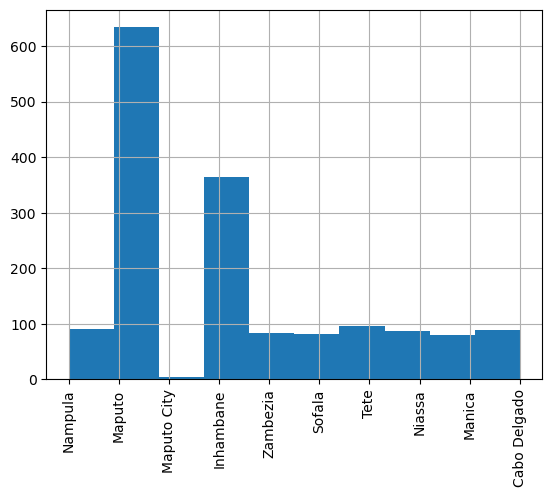

In [17]:
plt.grid()
plt.hist(ibd_res_meta['province'][ibd_res_meta['province'].notnull()], 10)
#plt.ylim(0,200)
plt.xticks(rotation = 90)
plt.show()

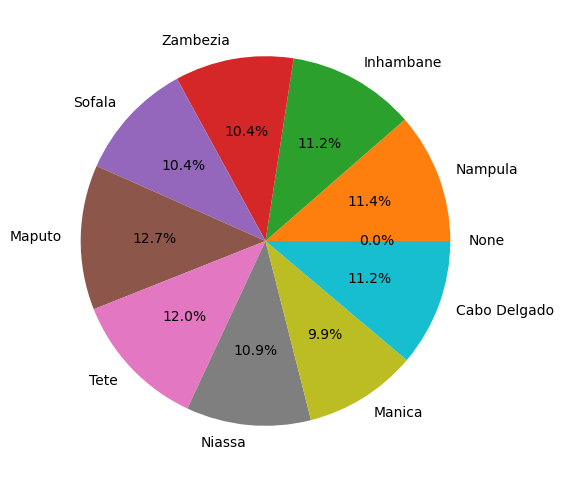

Number and fraction of cases:
None:         0	0.0%
Nampula:      90	11.4%
Inhambane:    88	11.2%
Zambezia:     82	10.4%
Sofala:       82	10.4%
Maputo:       100	12.7%
Tete:         95	12.0%
Niassa:       86	10.9%
Manica:       78	9.9%
Cabo Delgado: 88	11.2%


In [18]:
mask = ibd_res_meta['source'] == 'HFS'
make_pie(ibd_res_meta.loc[mask, 'province'], verbose = True, ignore_null=False)

run_id_resmark


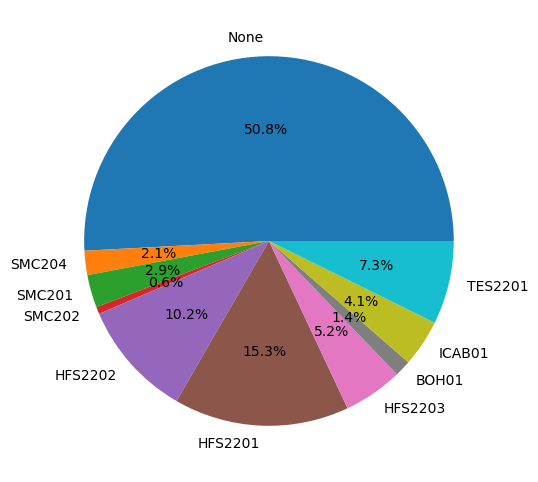

Number and fraction of cases:
None:    816	50.8%
SMC204:  34	2.1%
SMC201:  46	2.9%
SMC202:  10	0.6%
HFS2202: 164	10.2%
HFS2201: 246	15.3%
HFS2203: 83	5.2%
BOH01:   23	1.4%
ICAB01:  66	4.1%
TES2201: 117	7.3%

province


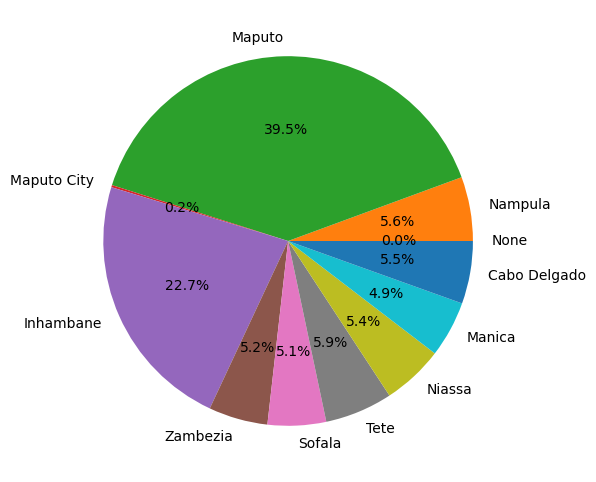

Number and fraction of cases:
None:         0	0.0%
Nampula:      90	5.6%
Maputo:       634	39.5%
Maputo City:  3	0.2%
Inhambane:    365	22.7%
Zambezia:     83	5.2%
Sofala:       82	5.1%
Tete:         95	5.9%
Niassa:       86	5.4%
Manica:       79	4.9%
Cabo Delgado: 88	5.5%

district


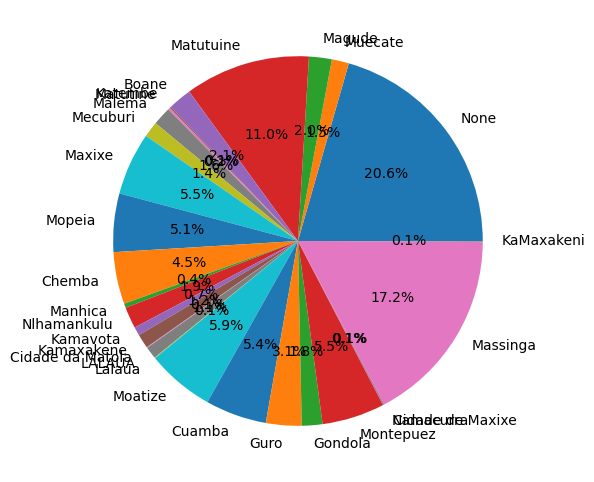

Number and fraction of cases:
None:             330	20.6%
Muecate:          24	1.5%
Magude:           32	2.0%
Matutuine:        176	11.0%
Boane:            33	2.1%
Katembe:          2	0.1%
Matutine:         3	0.2%
Malema:           26	1.6%
Mecuburi:         22	1.4%
Maxixe:           88	5.5%
Mopeia:           82	5.1%
Chemba:           73	4.5%
Manhica:          6	0.4%
Nlhamankulu:      30	1.9%
Kamavota:         12	0.7%
Kamaxakene:       20	1.2%
Cidade da Matola: 1	0.1%
LALAUA:           17	1.1%
Lalaua:           1	0.1%
Moatize:          95	5.9%
Cuamba:           86	5.4%
Guro:             50	3.1%
Gondola:          29	1.8%
Montepuez:        88	5.5%
Namacurra:        1	0.1%
Cidade de Maxixe: 1	0.1%
Massinga:         276	17.2%
KaMaxakeni:       1	0.1%

study


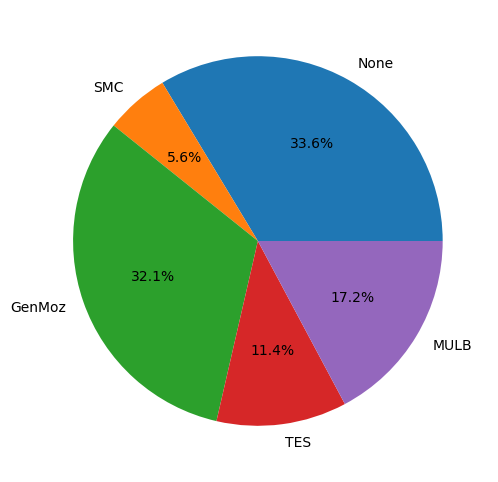

Number and fraction of cases:
None:   540	33.6%
SMC:    90	5.6%
GenMoz: 516	32.1%
TES:    183	11.4%
MULB:   276	17.2%



In [19]:
for var in ['run_id_resmark', 'province', 'district', 'study']:
    print(var)
    make_pie(ibd_res_meta[var], verbose = True, ignore_null=False)
    print()

Overall fraction of pairs with IBD >= 0.25 and p<= 0.05: 0.00535965382493921


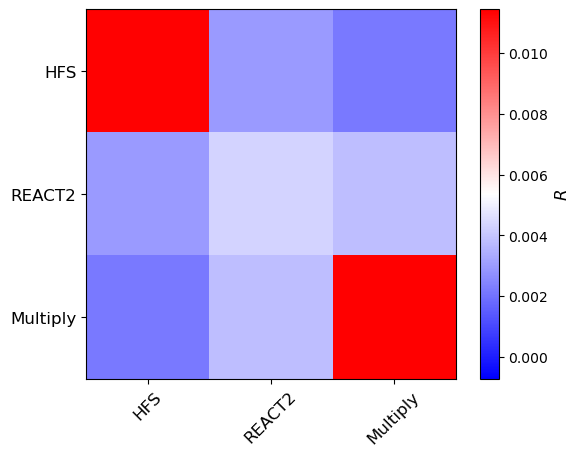

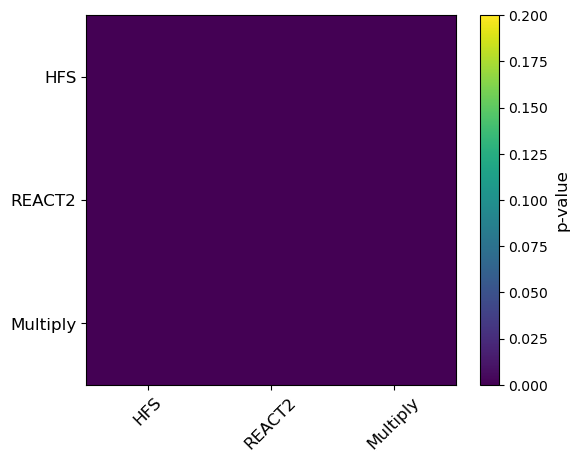

In [14]:
category_label = 'source'
categories = ['HFS', 'REACT2', 'Multiply']
max_p = .05
min_IBD = 0.25

ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                      cmap_label = r"$R$")

In [15]:
save_path = "/home/apujol/isglobal/manuscripts/importation_relatedness/figs/"

In [105]:
ibd_res

,N1817075_7_S124,N1817077_1_S146,N1817118_1_S94,N1817133_4_S111,N1817296_6_S147,N1817302_4_S149,N1817317_8_S105,N1817320_8_S125,N1817322_2_S48,N1817328_4_S110,...,N2084519_3_S316,N2084520_9_S317,N2084525_4_S319,N2084526_1_S180,N2084527_8_S166,N2084589_6_S318,N2084593_3_S172,N2084595_7_S278,N2084596_4_S174,N2084597_1_S285
N1817075_7_S124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N1817077_1_S146,0.440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N1817118_1_S94,0.082,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N1817133_4_S111,0.098,0.003,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N1817296_6_S147,0.000,0.070,0.148,0.083,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N2084589_6_S318,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.021,0.008,0.0,...,0.000,0.000,0.000,0.025,0.025,NaN,NaN,NaN,NaN,NaN
N2084593_3_S172,0.000,0.000,0.008,0.000,0.041,0.000,0.000,0.004,0.016,0.0,...,0.040,0.000,0.073,0.000,0.000,0.000,NaN,NaN,NaN,NaN
N2084595_7_S278,0.000,0.010,0.046,0.000,0.005,0.035,0.000,0.002,0.014,0.0,...,0.053,0.000,0.000,0.000,0.000,0.000,0.012,NaN,NaN,NaN
N2084596_4_S174,0.001,0.032,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0.028,0.059,0.000,0.000,0.000,0.033,0.074,0.0,NaN,NaN


Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


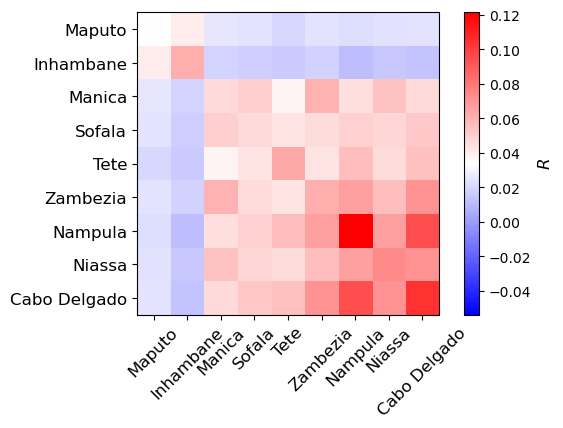

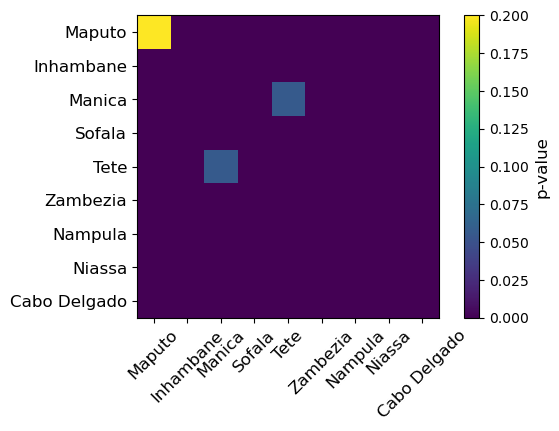

In [17]:
category_label = 'province'
categories = ['Maputo', 'Inhambane', \
              'Manica', 'Sofala', 'Tete', 'Zambezia', \
               'Nampula', 'Niassa', 'Cabo Delgado']
max_p = .05
min_IBD = 0.1

ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)
save_as = None
save_as = save_path + "ibd_provinces.pdf"
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as, cmap_label = r"$R$", subplot_adj=[None, None, None, .25])

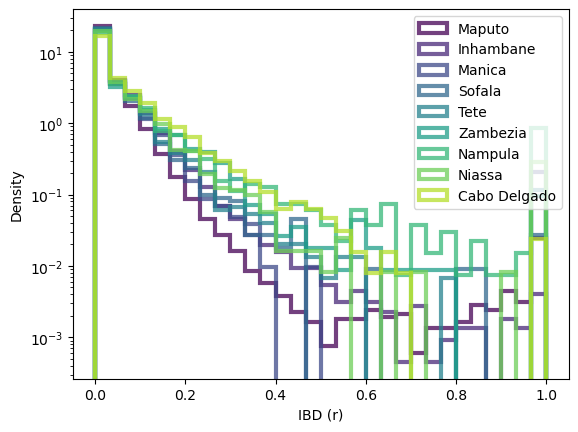

In [106]:
ibd_per_cat = classify_ibd_per_label(category_label, ibd_res_meta)
colors = [cm.viridis(i/(len(categories))) for i in range(len(categories))]
for ii,i in enumerate(categories):
    plt.hist(ibd_per_cat[i][i], 30, density = True, range = [0,1], label = str(i), \
             alpha = .75, histtype = 'step', color = colors[ii], lw = 3)
plt.xlabel('IBD (r)')
plt.ylabel('Density')
plt.yscale('log')
plt.legend(ncols = 1)
plt.savefig(save_path + "ibd_density_plot_provinces.pdf")
plt.savefig(save_path + "ibd_density_plot_provinces.png")
plt.show()

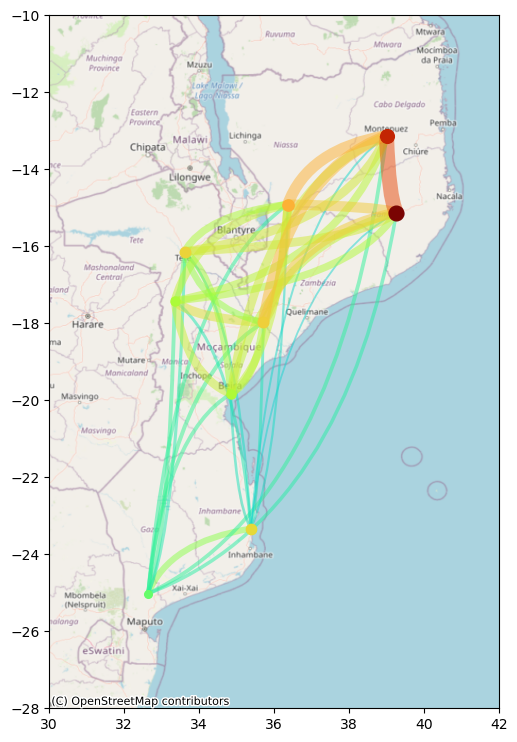

In [33]:
#using alpha
connectivity_map(ibdfrac_per_cat, categories, provinces, color = 'auto', linewidth = 'prop', print_locations=False)
plt.savefig(save_path + "ibd_map.pdf")
plt.savefig(save_path + "ibd_map.png")

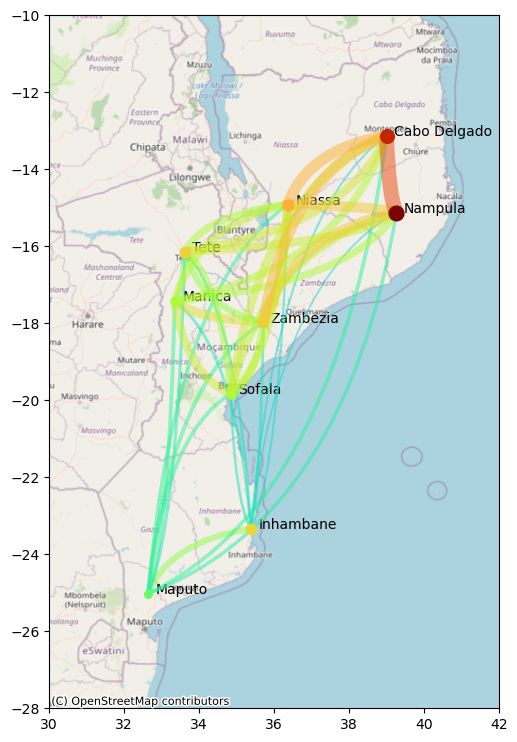

In [34]:
#using alpha
connectivity_map(ibdfrac_per_cat, categories, provinces, color = 'auto', linewidth = 'prop', print_locations=True)
plt.savefig(save_path + "ibd_map_locs.pdf")
plt.savefig(save_path + "ibd_map_locs.png")

Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


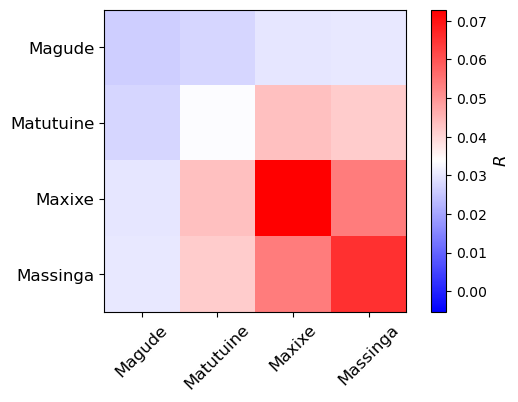

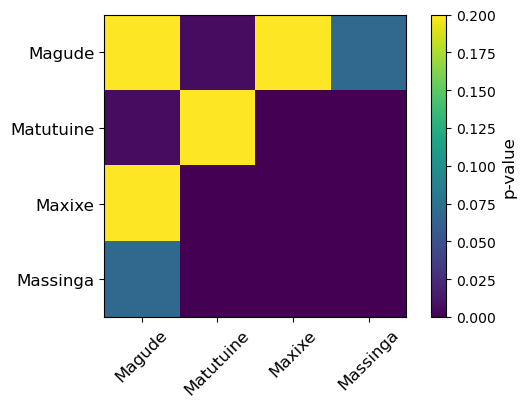

In [19]:
category_label = 'district'
categories = ['Magude', 'Matutuine', 'Maxixe', \
              'Massinga']
max_p = .05
min_IBD = 0.1

ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)
save_as = None
save_as = save_path + "ibd_districts.png"
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as, cmap_label = r"$R$", subplot_adj=[None, None, None, .25])

In [20]:
ibd_res_meta['region'] = pd.Series()
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo City', 'region'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo', 'region'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Inhambane', 'region'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Manica', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Sofala', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Tete', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Zambezia', 'region'] = 'Central'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Nampula', 'region'] = 'North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Niassa', 'region'] = 'North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Cabo Delgado', 'region'] = 'North'
ibd_pval_meta['region'] = ibd_res_meta['region']

Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


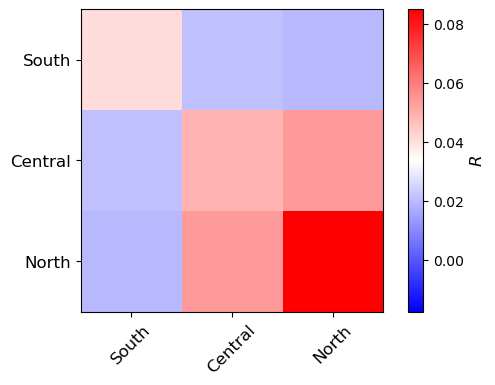

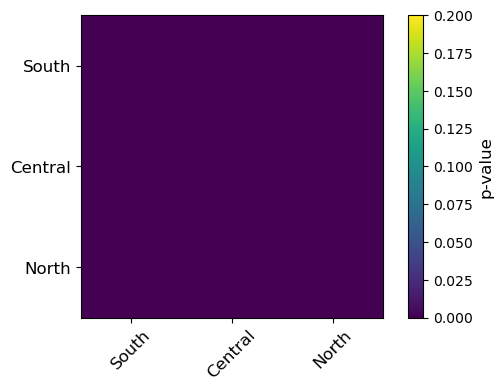

In [22]:
category_label = 'region'
categories = ['South', 'Central', 'North']
max_p = .05
min_IBD = 0.1

ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)

save_as = None
#save_as = save_path + "ibd_regions.png"
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as, cmap_label = r"$R$", subplot_adj=[None, None, None, .25])

Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


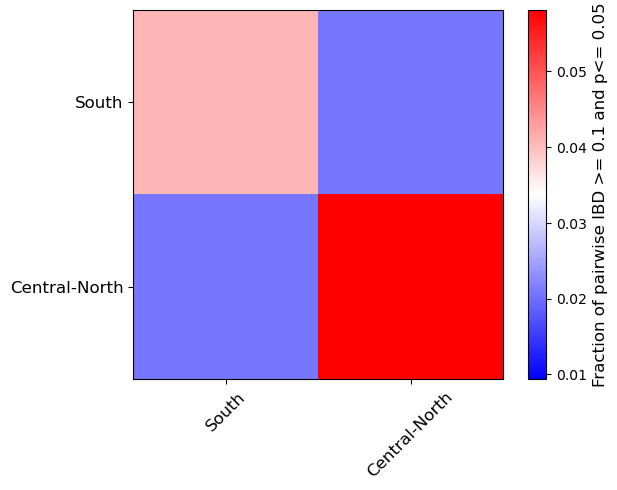

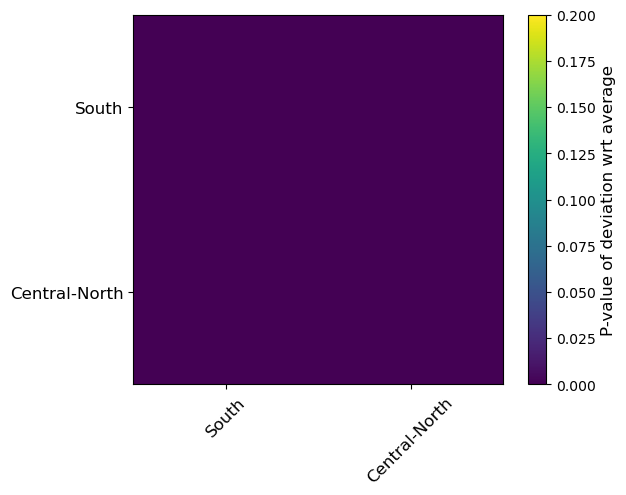

In [120]:
ibd_res_meta['regionSN'] = pd.Series()
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo City', 'regionSN'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Maputo', 'regionSN'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Inhambane', 'regionSN'] = 'South'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Manica', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Sofala', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Tete', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Zambezia', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Nampula', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Niassa', 'regionSN'] = 'Central-North'
ibd_res_meta.loc[ibd_res_meta['province'] == 'Cabo Delgado', 'regionSN'] = 'Central-North'
ibd_pval_meta['regionSN'] = ibd_res_meta['regionSN']

category_label = 'regionSN'
categories = ['South', 'Central-North']
max_p = .05
min_IBD = 0.1

ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories, \
                                                                                     verbose = True, perm_pval = False)

save_as = None
#save_as = save_path + "ibd_regions.pdf"
show_ibd_frac_per_cat(ibdfrac_per_cat, overall_high_ibd_frac, ibdfrac_pval_per_cat, min_IBD = min_IBD, max_p = max_p, \
                     save_as = save_as)

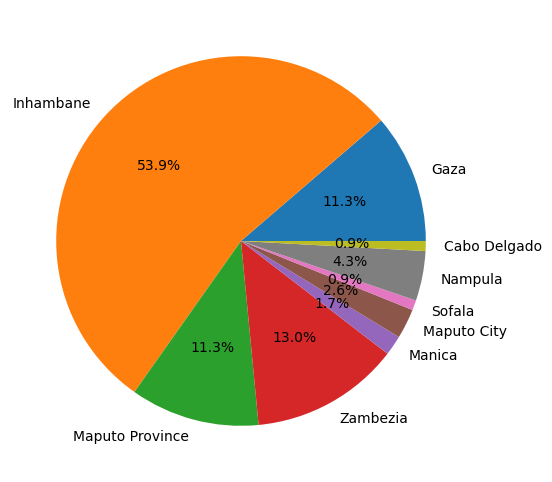

Number and fraction of cases:
Gaza:            13	11.3%
Inhambane:       62	53.9%
Maputo Province: 13	11.3%
Zambezia:        15	13.0%
Manica:          2	1.7%
Maputo City:     3	2.6%
Sofala:          1	0.9%
Nampula:         5	4.3%
Cabo Delgado:    1	0.9%


In [121]:
ibd_res_meta.loc[ibd_res_meta['travel_prov'] == 'Maputo Provincia', 'travel_prov'] = 'Maputo Province'
ibd_res_meta.loc[ibd_res_meta['travel_prov'] == 'Maputo Cidade', 'travel_prov'] = 'Maputo City'
save_as = None
#save_as = save_path + "travel_dest_pie.png"
make_pie(ibd_res_meta['travel_prov'], verbose=True, save_as = save_as)

In [122]:
table_prov_source = tables.labels_2d(ibd_res_meta, 'province', 'source')

In [123]:
table_prov_source

,HFS,REACT2,Multiply
Nampula,90.0,0.0,0.0
Maputo,100.0,534.0,0.0
Maputo City,0.0,3.0,0.0
Inhambane,88.0,1.0,276.0
Zambezia,82.0,1.0,0.0
Sofala,82.0,0.0,0.0
Tete,95.0,0.0,0.0
Niassa,86.0,0.0,0.0
Manica,78.0,1.0,0.0
Cabo Delgado,88.0,0.0,0.0


## Isolation-by-distance

### Inter-province distance level

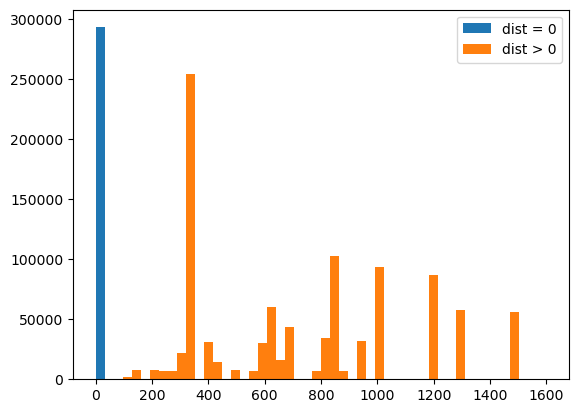

In [154]:
#Calculating pariwise inter-province distance matrix
x, y = np.array(ibd_res_meta['longitude_prov']), np.array(ibd_res_meta['latitude_prov'])
dist_matrix = clustering.all_distances(x, y, x, y)
#IBD results matrix 
ibd_mat = np.array(ibd_res)
p_mat = np.array(ibd_pval)
ibd_values = ibd_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
p_values = p_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
dist_values = dist_matrix[np.isfinite(ibd_mat)&np.isfinite(p_mat)]

plt.hist(dist_values,50, range = [0,1600], label = 'dist = 0')
plt.hist(dist_values,50, range = [1,1600], label = 'dist > 0')
plt.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:              1287210
Model:                            GLM   Df Residuals:                  1287208
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1456e+05
Date:                Sat, 26 Oct 2024   Deviance:                   2.2912e+05
Time:                        08:30:23   Pearson chi2:                 1.29e+06
No. Iterations:                     8   Pseudo R-squ. (CS):           0.001726
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6372      0.010   -377.499      0.0

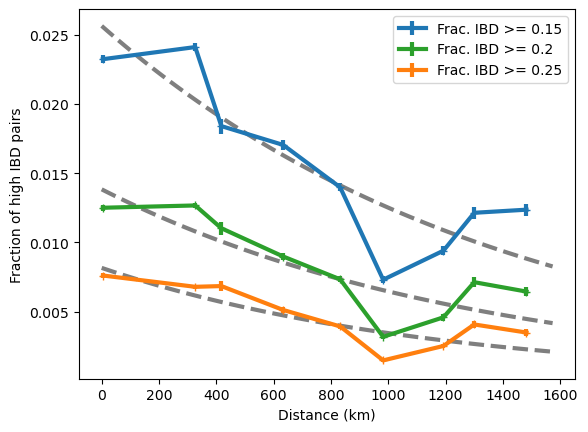

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               629861
Model:                            GLM   Df Residuals:                   629859
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68684.
Date:                Sat, 26 Oct 2024   Deviance:                   1.3737e+05
Time:                        08:30:49   Pearson chi2:                 6.30e+05
No. Iterations:                     7   Pseudo R-squ. (CS):          6.610e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6982      0.012   -310.464      0.0

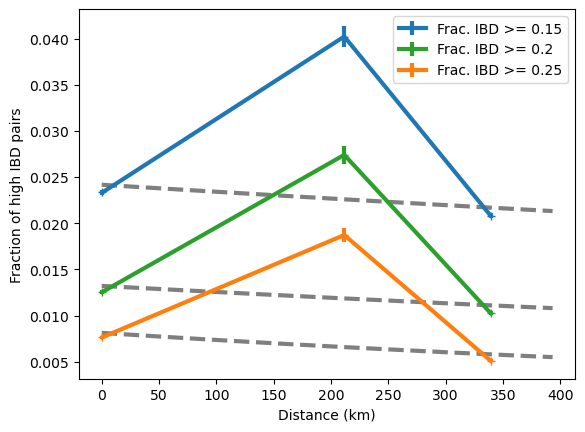

In [125]:
#Number of bins
ibd_thresholds = [.15, .2, .25]
colors = ['tab:blue', 'tab:green', 'tab:orange']
nbins = 10
nrands = 500
max_p = .05
min_dist = np.nanmin(dist_values)
max_dist = np.nanmax(dist_values)

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = 'tab:grey', lw = 3)
plt.legend()
plt.show()

nbins = 4
min_dist = 0
max_dist = 400

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = 'tab:grey', lw = 3)
plt.legend()
plt.show()

### Inter-HF level

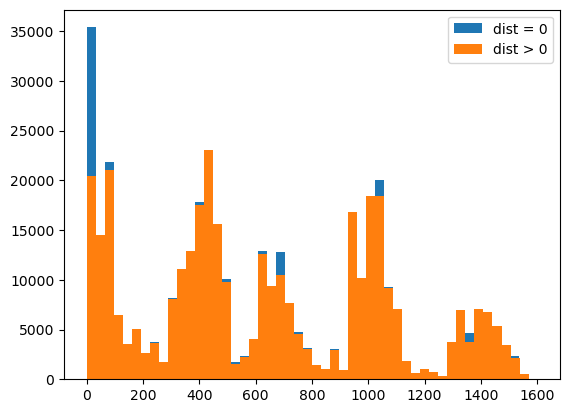

In [106]:
#Calculating pariwise inter-province distance matrix
x, y = np.array(ibd_res_meta['longitude_us'], dtype = float), np.array(ibd_res_meta['latitude_us'], dtype = float)
dist_matrix = clustering.all_distances(x, y, x, y)
#IBD results matrix 
ibd_mat = np.array(ibd_res)
p_mat = np.array(ibd_pval)
ibd_values = ibd_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
p_values = p_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
dist_values = dist_matrix[np.isfinite(ibd_mat)&np.isfinite(p_mat)]

plt.hist(dist_values,50, range = [0,1600], label = 'dist = 0')
plt.hist(dist_values,50, range = [1,1601], label = 'dist > 0')
plt.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               307255
Model:                            GLM   Df Residuals:                   307253
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24521.
Date:                Tue, 23 Jul 2024   Deviance:                       49042.
Time:                        14:57:40   Pearson chi2:                 3.11e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.001897
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4698      0.030   -115.998      0.0

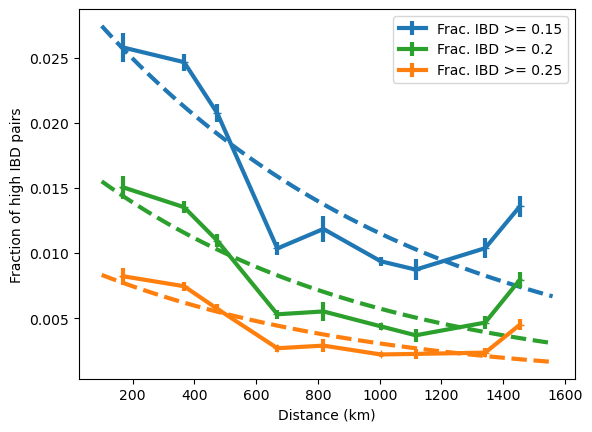

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                40122
Model:                            GLM   Df Residuals:                    40120
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4468.6
Date:                Tue, 23 Jul 2024   Deviance:                       8937.2
Time:                        14:57:45   Pearson chi2:                 4.01e+04
No. Iterations:                     7   Pseudo R-squ. (CS):          3.164e-06
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6888      0.111    -33.102      0.0

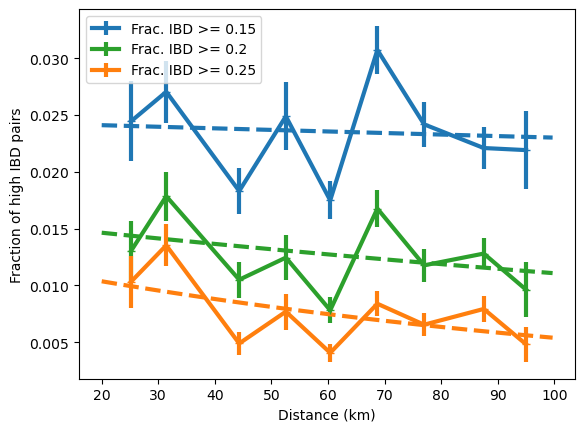

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                31508
Model:                            GLM   Df Residuals:                    31506
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4918.6
Date:                Tue, 23 Jul 2024   Deviance:                       9837.1
Time:                        14:57:46   Pearson chi2:                 3.15e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003371
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0009      0.037    -81.012      0.0

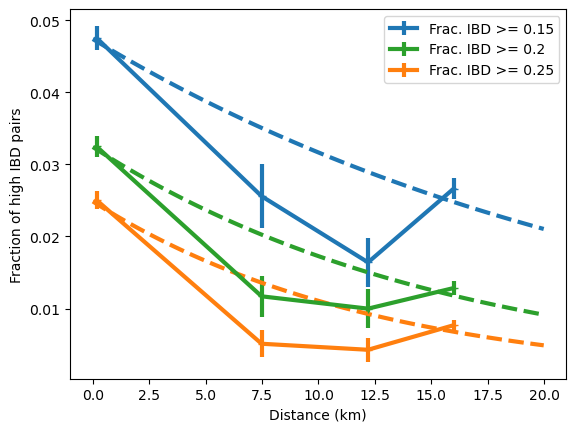

In [107]:
#Number of bins
ibd_thresholds = [.15, .2, .25]
colors = ['tab:blue', 'tab:green', 'tab:orange']
nbins = 10
nrands = 500
max_p = .05
min_dist = 100 #np.nanmin(dist_values)
max_dist = np.nanmax(dist_values)

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

nbins = 10
min_dist = 20
max_dist = 100

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

nbins = 5
min_dist = 0
max_dist = 20

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

## Household level

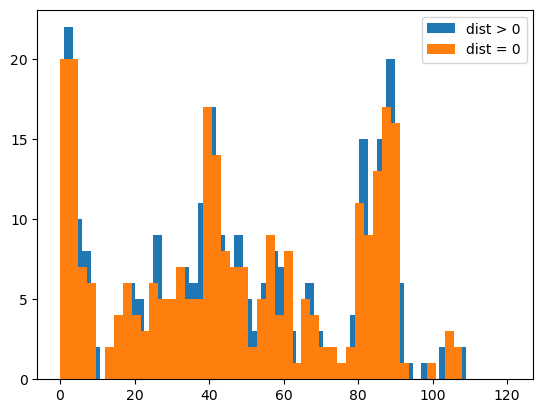

In [155]:
#Calculating pariwise inter-province distance matrix
x, y = np.array(ibd_res_meta['longitude'], dtype = float), np.array(ibd_res_meta['latitude'], dtype = float)
dist_matrix = clustering.all_distances(x, y, x, y)
#IBD results matrix 
ibd_mat = np.array(ibd_res)
p_mat = np.array(ibd_pval)
ibd_values = ibd_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
p_values = p_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
dist_values = dist_matrix[np.isfinite(ibd_mat)&np.isfinite(p_mat)]


plt.hist(dist_values,50, range = [1,121], label = 'dist > 0')
plt.hist(dist_values,50, range = [0,120], label = 'dist = 0')
plt.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  218
Model:                            GLM   Df Residuals:                      216
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40.571
Date:                Tue, 23 Jul 2024   Deviance:                       81.142
Time:                        14:58:01   Pearson chi2:                     218.
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0001391
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1705      0.850     -3.728      0.0

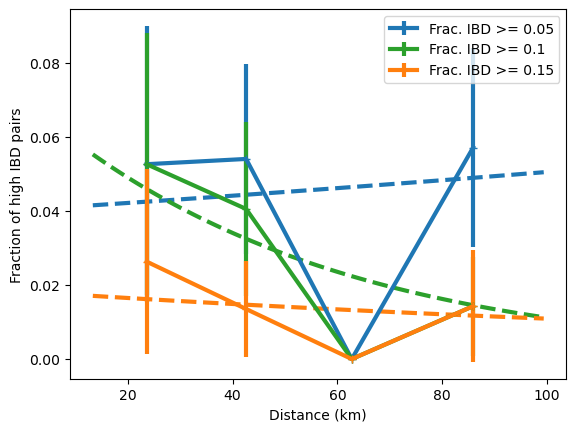

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   53
Model:                            GLM   Df Residuals:                       51
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9.0026
Date:                Tue, 23 Jul 2024   Deviance:                       18.005
Time:                        14:58:01   Pearson chi2:                     28.2
No. Iterations:                     7   Pseudo R-squ. (CS):            0.09092
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6017      1.915     -2.925      0.0

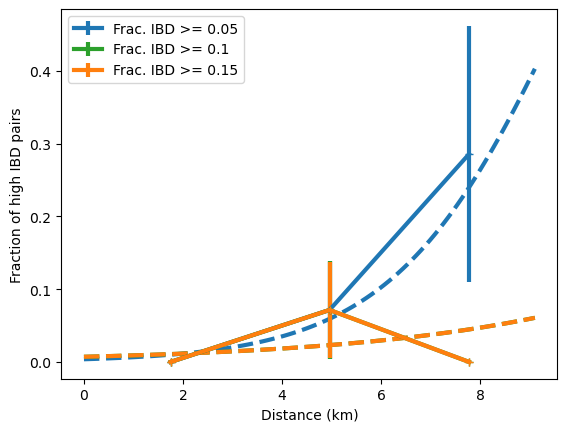

In [110]:
#Number of bins
ibd_thresholds = [.05, .1, .15]
colors = ['tab:blue', 'tab:green', 'tab:orange']

nbins = 5
min_dist = 10
max_dist = 100

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

nbins = 4
min_dist = 0
max_dist = 10

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

## Household and US (when no household available) level

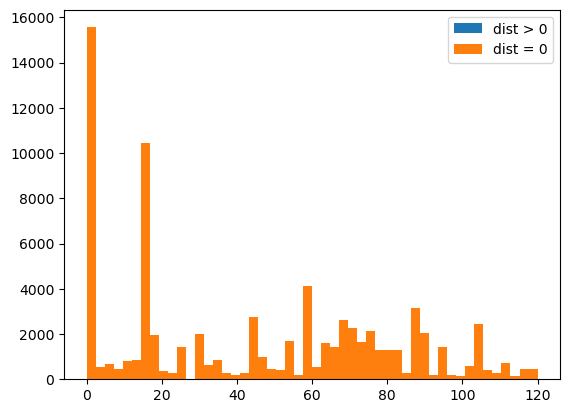

In [156]:
#Calculating pariwise inter-province distance matrix
x, y = np.array(ibd_res_meta['longitude'], dtype = float), np.array(ibd_res_meta['latitude'], dtype = float)
dist_matrix = clustering.all_distances(x, y, x, y)
x, y = np.array(ibd_res_meta['longitude_us'], dtype = float), np.array(ibd_res_meta['latitude_us'], dtype = float)
dist_matrix_us = clustering.all_distances(x, y, x, y)

for i in range(dist_matrix.shape[0]):
    for j in range(dist_matrix.shape[1]):
        if np.isnan(dist_matrix[i,j]):
            dist_matrix[i,j] = dist_matrix_us[i,j]
            
#IBD results matrix 
ibd_mat = np.array(ibd_res)
p_mat = np.array(ibd_pval)
ibd_values = ibd_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
p_values = p_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
dist_values = dist_matrix[np.isfinite(ibd_mat)&np.isfinite(p_mat)]


plt.hist(dist_values,50, range = [0,120], label = 'dist > 0')
plt.hist(dist_values,50, range = [0,120], label = 'dist = 0')
plt.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               286246
Model:                            GLM   Df Residuals:                   286244
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24343.
Date:                Sat, 26 Oct 2024   Deviance:                       48685.
Time:                        08:37:17   Pearson chi2:                 2.89e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.002579
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2774      0.030   -107.513      0.0

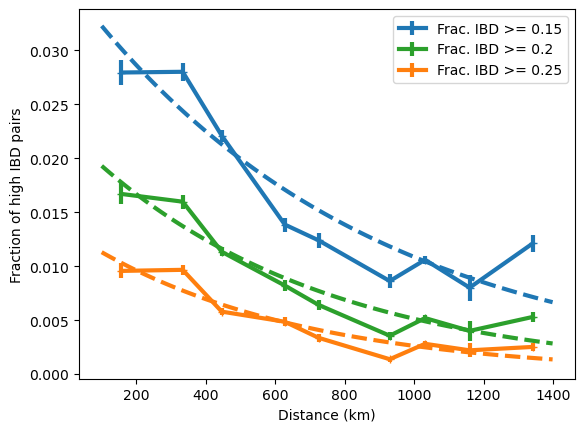

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                54127
Model:                            GLM   Df Residuals:                    54125
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6418.4
Date:                Sat, 26 Oct 2024   Deviance:                       12837.
Time:                        08:37:22   Pearson chi2:                 5.41e+04
No. Iterations:                     7   Pseudo R-squ. (CS):          4.328e-06
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6701      0.059    -62.373      0.0

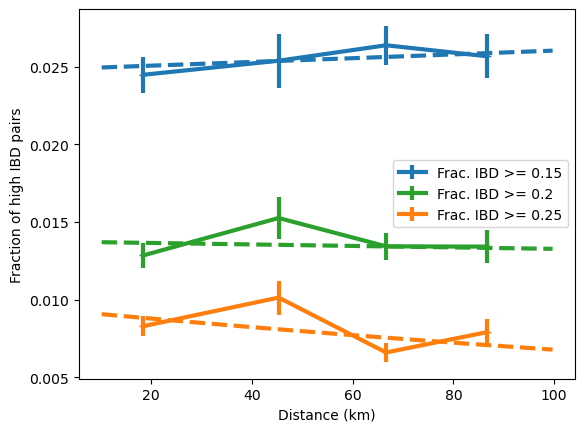

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                17498
Model:                            GLM   Df Residuals:                    17496
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3430.6
Date:                Sat, 26 Oct 2024   Deviance:                       6861.2
Time:                        08:37:23   Pearson chi2:                 1.75e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001239
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9054      0.036    -80.341      0.0

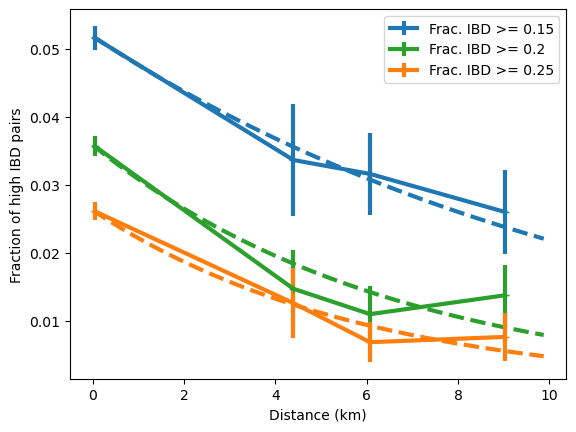

In [158]:
#Number of bins
ibd_thresholds = [.15, .2, .25]
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:grey']

nbins = 10
min_dist = 100
max_dist = 1400

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

nbins = 5
min_dist = 10
max_dist = 100

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

nbins = 5
min_dist = 0
max_dist = 10

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               286246
Model:                            GLM   Df Residuals:                   286244
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22953.
Date:                Tue, 23 Jul 2024   Deviance:                       45906.
Time:                        14:58:56   Pearson chi2:                 2.89e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.002428
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3476      0.032   -105.996      0.0

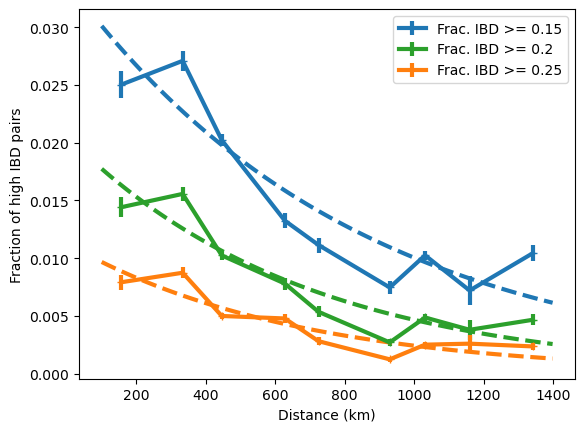

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                54127
Model:                            GLM   Df Residuals:                    54125
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6138.4
Date:                Tue, 23 Jul 2024   Deviance:                       12277.
Time:                        14:59:01   Pearson chi2:                 5.41e+04
No. Iterations:                     7   Pseudo R-squ. (CS):          3.369e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6320      0.059    -61.348      0.0

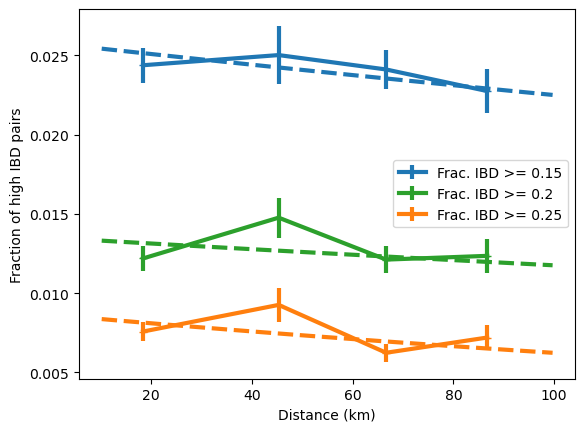

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                17498
Model:                            GLM   Df Residuals:                    17496
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3245.5
Date:                Tue, 23 Jul 2024   Deviance:                       6491.0
Time:                        14:59:03   Pearson chi2:                 1.75e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001166
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9834      0.037    -79.650      0.0

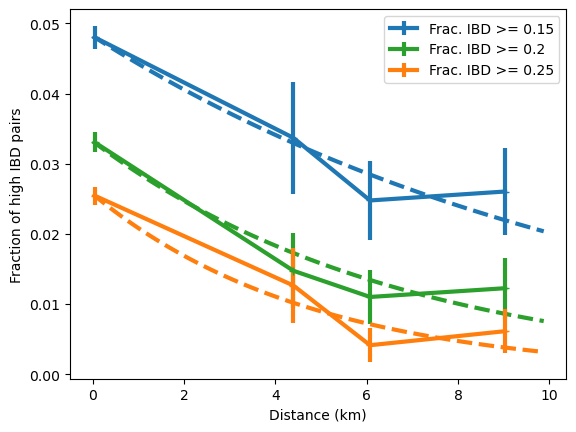

In [112]:
#Number of bins
ibd_thresholds = [.15, .2, .25]
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:grey']

nbins = 10
min_dist = 100
max_dist = 1400

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

nbins = 5
min_dist = 10
max_dist = 100

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

nbins = 5
min_dist = 0
max_dist = 10

for c, ibd_threshold in enumerate(ibd_thresholds):
    mean_high_ibd_frac_vs_dist(ibd_values, dist_values, p_values, ibd_threshold, max_p, nbins, min_dist, \
                               max_dist, nrands, label = "Frac. IBD >= " + str(ibd_threshold), \
                              show = False, get_glm = True, verbose = True, c = colors[c], \
                               c2 = colors[c], lw = 3)
plt.legend()
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".pdf")
#plt.savefig(save_path + "ibd_vs_dist_"+str(min_dist) + "_" + str(max_dist)+".png")
plt.show()

## Spatio-temporal IBD (US level) --- Analysis not conducted with final data (July 18 2024)

In [45]:
#Calculating pairwise time distance matrix
timedist_matrix = np.zeros((ibd_res_meta.shape[0], ibd_res_meta.shape[0]))
for i in range(ibd_res_meta.shape[0]):
    for j in range(ibd_res_meta.shape[0]):
        timedist_matrix[i,j] = (ibd_res_meta.iloc[i]['date'] - ibd_res_meta.iloc[j]['date'])/pd.to_timedelta(1, unit='D')

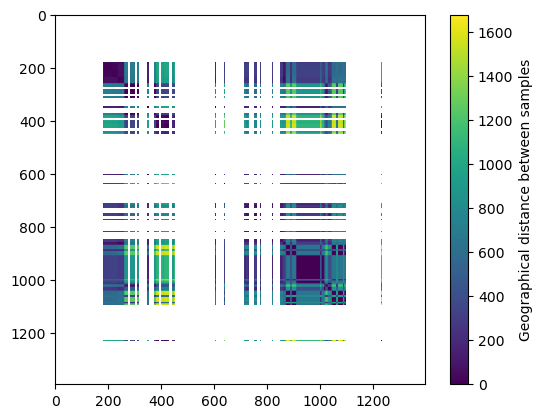

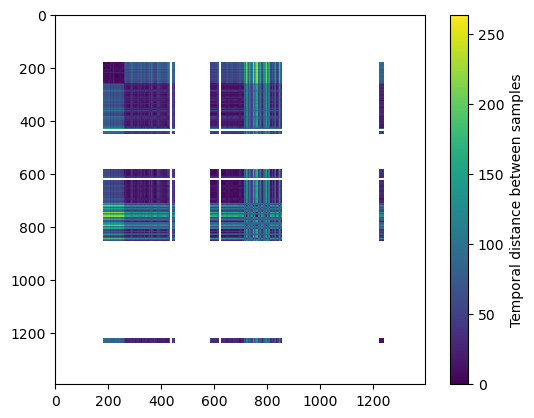

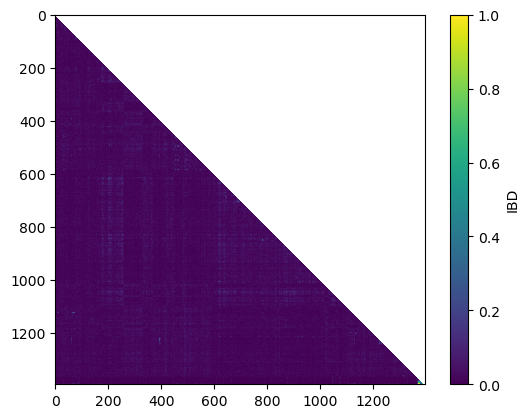

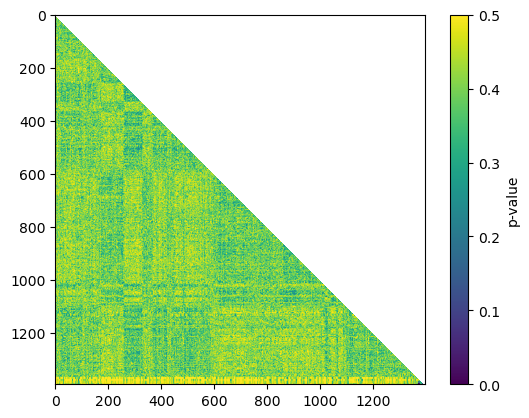

In [77]:
plt.imshow(dist_matrix)
plt.colorbar(label = "Geographical distance between samples")
plt.show()

plt.imshow(np.abs(timedist_matrix))
plt.colorbar(label = "Temporal distance between samples")
plt.show()

plt.imshow(ibd_res)
plt.colorbar(label = "IBD")
plt.show()

plt.imshow(ibd_pval)
plt.colorbar(label = "p-value")
plt.show()

In [17]:
ibd_threshold = .25
pval_threshold = .05

spatial_edges = np.linspace(0,200, 10)
temporal_edges = np.linspace(0, 240, 10)

dist_bins = len(spatial_edges) - 1
temp_bins = len(temporal_edges) - 1
mean_distances = np.zeros(dist_bins)
mean_times = np.zeros(temp_bins)
ibd_frac = np.zeros((dist_bins, temp_bins))
for s in range(dist_bins):
    #Masks of distances
    s_mask = (dist_matrix >= spatial_edges[s])&(dist_matrix < spatial_edges[s + 1])
    #Calculate mean_distances
    mean_distances[s] = np.nanmean(dist_matrix[s_mask])
    for t in range(temp_bins):
        #Masks of time differences and IBD threshold
        t_mask = (timedist_matrix >= temporal_edges[t])&(timedist_matrix < temporal_edges[t + 1])
        ibd_mask = (ibd_res >= ibd_threshold)&(ibd_pval <= pval_threshold)
        #calculate mean time differences
        if s == 0:
            mean_times[t] = np.nanmean(timedist_matrix[t_mask])
        ibd_frac[s,t] = np.nanmean(ibd_mask[t_mask&s_mask])

NameError: name 'timedist_matrix' is not defined

In [93]:
ibd_threshold = .25
pval_threshold = .05

spatial_edges = np.linspace(0,200, 10)
temporal_edges = np.linspace(0, 240, 10)

dist_bins = len(spatial_edges) - 1
temp_bins = len(temporal_edges) - 1
mean_distances = np.zeros(dist_bins)
mean_times = np.zeros(temp_bins)
ibd_frac = np.zeros((dist_bins, temp_bins))
for s in range(dist_bins):
    #Masks of distances
    s_mask = (dist_matrix >= spatial_edges[s])&(dist_matrix < spatial_edges[s + 1])
    #Calculate mean_distances
    mean_distances[s] = np.nanmean(dist_matrix[s_mask])
    for t in range(temp_bins):
        #Masks of time differences and IBD threshold
        t_mask = (timedist_matrix >= temporal_edges[t])&(timedist_matrix < temporal_edges[t + 1])
        ibd_mask = (ibd_res >= ibd_threshold)&(ibd_pval <= pval_threshold)
        #calculate mean time differences
        if s == 0:
            mean_times[t] = np.nanmean(timedist_matrix[t_mask])
        ibd_frac[s,t] = np.nanmean(ibd_mask[t_mask&s_mask])

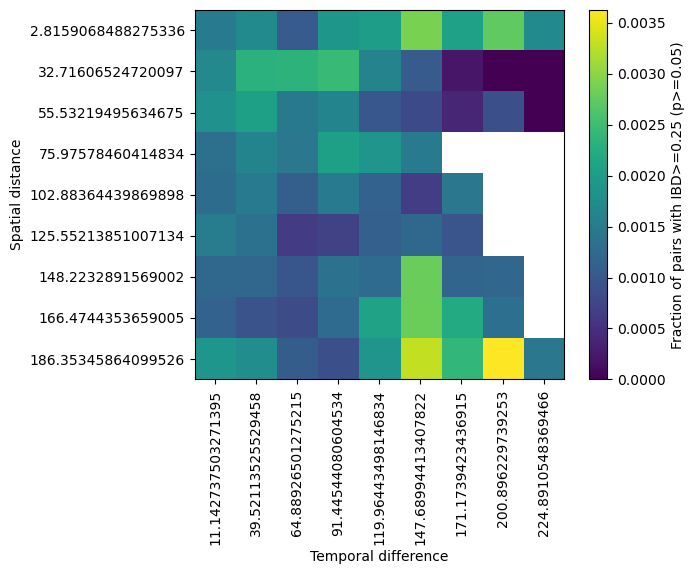

In [94]:
plt.imshow(ibd_frac)
plt.colorbar(label = "Fraction of pairs with IBD>=" + str(ibd_threshold) + " (p>=" + str(pval_threshold) + ")")
plt.yticks(ticks = range(dist_bins), labels = mean_distances)
plt.ylabel('Spatial distance')
plt.xticks(ticks = range(temp_bins), labels = mean_times, rotation = 90)
plt.xlabel('Temporal difference')
plt.show()

In [95]:
#IBD results matrix 
ibd_mat = np.array(ibd_res)
p_mat = np.array(ibd_pval)
ibd_values = ibd_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
p_values = p_mat[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
dist_values = dist_matrix[np.isfinite(ibd_mat)&np.isfinite(p_mat)]
temp_values = timedist_matrix[np.isfinite(ibd_mat)&np.isfinite(p_mat)]

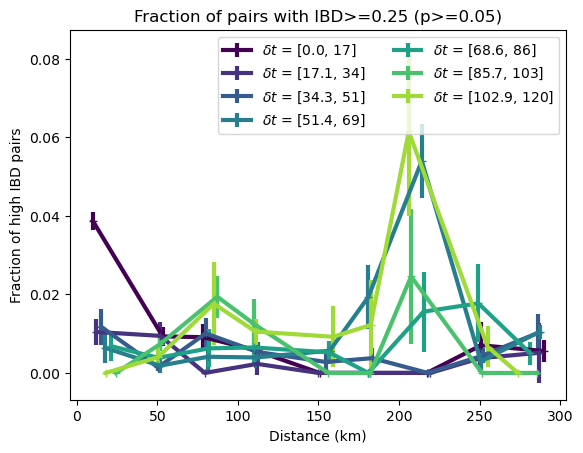

In [96]:
#Number of bins
ibd_threshold = .25
pval_threshold = .05
temporal_edges = np.linspace(0, 120, 8)
nbins = 10
nrands = 10

min_dist = np.nanmin(dist_values)
max_dist = 300 #np.nanmax(dist_values)
temp_bins = len(temporal_edges) - 1
colors = [cm.viridis(i/temp_bins) for i in range(temp_bins)]

for t in range(temp_bins):
    mask = (temp_values >= temporal_edges[t])&(temp_values < temporal_edges[t + 1])
    t1 = str(round(temporal_edges[t],1))
    t2 = str(round(temporal_edges[t + 1]))
    mean_high_ibd_frac_vs_dist(ibd_values[mask], dist_values[mask], p_values[mask], ibd_threshold, pval_threshold, nbins, min_dist, \
                               max_dist, nrands, label = r"$\delta t$ = [" + t1 + ", " + t2 + "]",
                              show = False, get_glm = False, verbose = False, c = colors[t], \
                               c2 = 'tab:grey', lw = 3)
plt.title("Fraction of pairs with IBD>=" + str(ibd_threshold) + " (p>=" + str(pval_threshold) + ")")
plt.legend(ncol = 2)
plt.show()

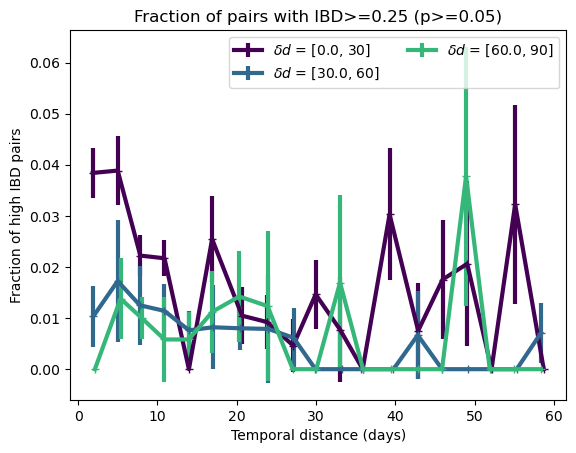

In [126]:
#Number of bins
ibd_threshold = .25
pval_threshold = .05
spatial_edges = np.linspace(0, 90, 4)
nbins = 20
nrands = 10

min_dist = .00001 #np.nanmin(dist_values)
max_dist = 60 #np.nanmax(dist_values)
dist_bins = len(spatial_edges) - 1
colors = [cm.viridis(i/dist_bins) for i in range(dist_bins)]

for t in range(dist_bins):
    mask = (dist_values >= spatial_edges[t])&(dist_values < spatial_edges[t + 1])
    t1 = str(round(spatial_edges[t],1))
    t2 = str(round(spatial_edges[t + 1]))
    mean_high_ibd_frac_vs_dist(ibd_values[mask], temp_values[mask], p_values[mask], ibd_threshold, \
                               pval_threshold, nbins, min_dist, \
                               max_dist, nrands, label = r"$\delta d$ = [" + t1 + ", " + t2 + "]",
                              show = False, get_glm = False, verbose = False, c = colors[t], \
                               c2 = 'tab:grey', lw = 3)
plt.xlabel("Temporal distance (days)")
plt.title("Fraction of pairs with IBD>=" + str(ibd_threshold) + " (p>=" + str(pval_threshold) + ")")
plt.legend(ncol = 2)
plt.show()

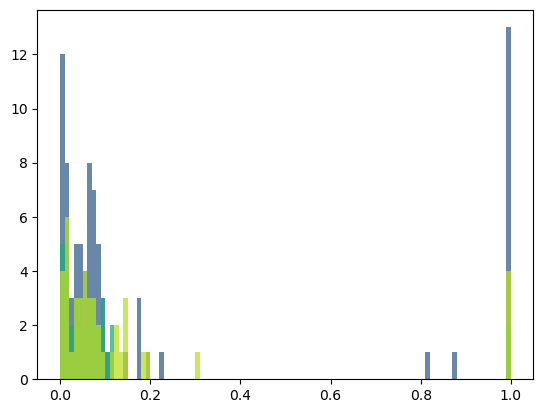

In [130]:
#plt.hist(ibd_values[(temp_values == 0)&(dist_values == 0)], 100, range = [.00001, 1], alpha = .75, color = cm.viridis(0))
plt.hist(ibd_values[(temp_values == 1)&(dist_values == 0)], 100, range = [.00001, 1], alpha = .75, color = cm.viridis(0.3))
plt.hist(ibd_values[(temp_values == 2)&(dist_values == 0)], 100, range = [.00001, 1], alpha = .75, color = cm.viridis(0.6))
plt.hist(ibd_values[(temp_values == 3)&(dist_values == 0)], 100, range = [.00001, 1], alpha = .75, color = cm.viridis(0.9))
plt.show()